## Library

In [1]:
!pip install transformers
!pip install sentence_transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=d531395da619eefb7e84ea814877e6935063a3ab1201407648978cee0232520c
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.1 MB/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from transformers import AutoModelForSequenceClassification,Trainer,AutoTokenizer,TrainingArguments
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,precision_score
from sklearn.model_selection import train_test_split

In [2]:
%cd /content/drive/MyDrive/classification

/content/drive/MyDrive/classification


## Data preprocessing

In [3]:
# Modify the number to load a different dataset
dataset = "3"

if dataset == "1":

    df = pd.read_excel("./BERT/BERT/1/Constraint_Train.xlsx")
    prompt = "Real news or fake news:"
    df['tweet'] = df['tweet'].apply(lambda x: f"{prompt} {x}")
    #df = pd.read_excel("Constraint_Train.xlsx")
    # test_df  = pd.read_excel("./BERT/BERT/1/Constraint_Test.xlsx")

elif dataset == "2":

    df = pd.read_excel("./BERT/BERT/2/texts_labeled_cleaned.xlsx")
    #df = pd.read_excel("texts_labeled_cleaned.xlsx")
    df.columns = ["tweet","label"]
    prompt = "Real news or fake news:"
    df['tweet'] = df['tweet'].apply(lambda x: f"{prompt} {x}")

    df,test_df = train_test_split(df,test_size=0.1,random_state=12)

elif dataset == "3":

    train = pd.read_csv('./BERT/BERT/3/train.csv',delimiter='\t')
    test = pd.read_csv('./BERT/BERT/3/test.csv',delimiter='\t')
    valid = pd.read_csv('./BERT/BERT/3/valid.csv',delimiter='\t')
    #train = pd.read_csv('train.csv',delimiter='\t')
    #test = pd.read_csv('test.csv',delimiter='\t')
    #valid = pd.read_csv('valid.csv',delimiter='\t')

    replace_dict = {'half-true': 0, 'mostly-true': 0, 'false': 0, 'true': 1, 'barely-true': 0, 'pants-fire': 0}

    train['false'] = train['false'].replace(replace_dict)

    test['true'] = test['true'].replace(replace_dict)

    valid['barely-true'] = valid['barely-true'].replace(replace_dict)

    value_counts = train['false'].value_counts()

    label_train = train['false'].tolist()
    label_test = test['true'].tolist()
    train_set = train['Says the Annies List political group supports third-trimester abortions on demand.'].tolist()
    test_set = test['Building a wall on the U.S.-Mexico border will take literally years.'].tolist()
    unlabeled = valid['We have less Americans working now than in the 70s.'].tolist()
    df = pd.DataFrame({"tweet" : train_set + test_set,
              "label" : label_train + label_test })
    prompt = "Real news or fake news:"
    df['tweet'] = df['tweet'].apply(lambda x: f"{prompt} {x}")

    test_df = pd.DataFrame({"tweet" : unlabeled} )




class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

encoder     = LabelEncoder()
df['label'] = encoder.fit_transform( df['label'] )

In [4]:
df

,tweet,label
0,Real news or fake news: When did the decline o...,0
1,Real news or fake news: Hillary Clinton agrees...,0
2,Real news or fake news: Health care reform leg...,0
3,Real news or fake news: The economic turnaroun...,0
4,Real news or fake news: The Chicago Bears have...,1
...,...,...
11500,Real news or fake news: Says his budget provid...,0
11501,Real news or fake news: Ive been here almost e...,0
11502,"Real news or fake news: In the early 1980s, Se...",0
11503,Real news or fake news: Says an EPA permit lan...,0


## Loading model from the Transformers library

In [5]:
model_name =  "Mikael110/llama-2-7b-guanaco-fp16"
#model_name =  "TheBloke/guanaco-7B-GGML"
from transformers import LlamaForSequenceClassification, LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained(model_name)

id2label = {0 : 0  }
label2id = {0 : 0}

model = LlamaForSequenceClassification.from_pretrained(model_name,num_labels=1, id2label=id2label, label2id=label2id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at Mikael110/llama-2-7b-guanaco-fp16 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
train_df,val_df = train_test_split(df,test_size=0.2,random_state=12)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    # model.resize_token_embeddings(len(tokenizer))

train_encoding =  tokenizer(train_df['tweet'].values.tolist(), truncation=True, padding=True, max_length=128)
val_encoding   = tokenizer(val_df['tweet'].values.tolist(), truncation=True, padding=True, max_length=128)
train_dataset = TextDataset(train_encoding,train_df['label'].values.tolist())
val_dataset   = TextDataset(val_encoding,val_df['label'].values.tolist())


## Extract Embedding

In [7]:
from tqdm.auto import tqdm

In [8]:
import torch

# Check for available GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))

else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


There are 1 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


In [9]:
model.to(device)

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (nor

In [10]:
def embedding_data(sets):
    loader = DataLoader(sets, shuffle=False, batch_size=1)
    data, label = [], []
    for batch in tqdm(loader):
        try:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)
            embedding = out.past_key_values[0][0][0].mean(axis=-1).reshape(-1).detach().cpu().numpy()

            data.append(embedding)
            label.append(batch["labels"].cpu().item())
        except Exception as e:
            print(f"An error occurred: {e}")
            continue
    return np.array(data), np.array(label)

In [11]:
train_embedding,train_label = embedding_data(train_dataset)

  0%|          | 0/9204 [00:00<?, ?it/s]

In [12]:
val_embedding,val_label = embedding_data(val_dataset)

  0%|          | 0/2301 [00:00<?, ?it/s]

In [13]:
train_embedding.shape

(9204, 4096)

In [14]:
val_embedding.shape

(2301, 4096)

In [15]:
train_label.shape

(9204,)

In [16]:
val_label.shape

(2301,)

## Traditional classifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

In [18]:
def compute_metrics(model_name,predict,true):
    return {
        "model_name" : model_name,
        "accuracy" : accuracy_score(true,predict),
        "f1" : f1_score(true,predict),
        "precision" : precision_score(true,predict)
    }

In [19]:
models = [KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier,MLPClassifier]
result = []
for m in models:
    model = m()
    model.fit(train_embedding,
              train_label)

    val_predict = model.predict(val_embedding)

    result.append(compute_metrics(m.__name__,
                                  val_predict,
                                  val_label))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't c

In [20]:
print("dataset:",dataset)

pd.DataFrame(result)

dataset: 3


,model_name,accuracy,f1,precision
0,KNeighborsClassifier,0.820078,0.075893,0.204819
1,LogisticRegression,0.841373,0.000000,0.000000
2,DecisionTreeClassifier,0.709691,0.199041,0.176972
3,MLPClassifier,0.804433,0.096386,0.180451


## KNN method

In [21]:
from tqdm.auto import tqdm

Ks = [1,2,3,4,5,6,7,8,9,10,20,30]

result = []

for k in tqdm(Ks):
    model = KNeighborsClassifier(n_neighbors=k)

    model.fit(train_embedding,train_label)

    val_predict = model.predict(val_embedding)

    result.append(compute_metrics("{}".format(k),
                                  val_predict,
                                  val_label))


  0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
knndf = pd.DataFrame(result)

knndf.columns = ["K","accuracy","f1","precision"]
knndf.index = knndf.K

knndf = knndf.drop(columns = ["K"])
knndf

,accuracy,f1,precision
K,,,
1,0.739244,0.186992,0.184987
2,0.829205,0.070922,0.258621
3,0.794872,0.129151,0.197740
4,0.832681,0.039900,0.222222
5,0.820078,0.075893,0.204819
6,0.838331,0.031250,0.315789
7,0.832681,0.054054,0.261905
8,0.839635,0.010724,0.250000
9,0.834420,0.015504,0.136364


<Axes: xlabel='K'>

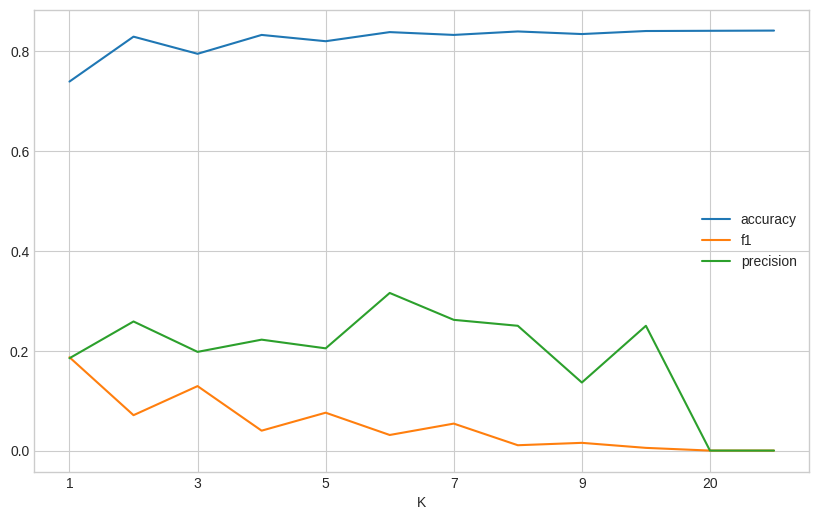

In [23]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

fig,ax = plt.subplots(1,1,figsize=(10,6))
knndf.plot(ax = ax)

In [24]:
train_label = train_df["label"].tolist()
val_label   = val_df["label"].tolist()

In [25]:
print(train_embedding.shape)
print(val_embedding.shape)

(9204, 4096)
(2301, 4096)


## CNN realization

In [26]:
X_train = torch.tensor(train_embedding, dtype=torch.float32)
y_train = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(val_embedding, dtype=torch.float32)
y_val = torch.tensor(val_label, dtype=torch.float32).unsqueeze(1)

In [27]:
class FakeNewsClassifierCNN(nn.Module):
    def __init__(self):
        super(FakeNewsClassifierCNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce dimension by half

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce dimension by half

        # Fully connected layers - adjust the input features accordingly
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Adjust the reshaping of the input to suit your embedding
        x = x.view(-1, 1, 64, 64)  # Reshaping from 4096 to (1, 64, 64)

        # First conv block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)

        # Second conv block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [28]:
from torch.utils.data import DataLoader, TensorDataset

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [29]:
import torch
import torch.nn as nn
import numpy as np
import random

# Setting random seeds for repeatable results
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

# Check for available GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialise model and move to GPU
model = FakeNewsClassifierCNN().to(device)

# Defining loss and optimiser
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training cycle
num_epochs = 200

best_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        batch_y = batch_y.view(-1, 1).float()

        optimizer.zero_grad()

        outputs = model(batch_x)
        outputs = torch.sigmoid(outputs) # Applying the sigmoid activation function
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

    # verification stage
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y = batch_y.view(-1, 1).float()

            outputs = model(batch_x)
            outputs = torch.sigmoid(outputs)  # Applying the sigmoid activation function
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    current_accuracy = correct/total*100
    print(f"Accuracy on validation data: {current_accuracy:.2f}%")

    # Save the highest accuracy rate
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy

print(f"Highest Accuracy on validation data: {best_accuracy:.2f}%")


Epoch 1/200, Loss: 0.47164258919656277
Accuracy on validation data: 84.14%
Epoch 2/200, Loss: 0.46051205104837817
Accuracy on validation data: 84.14%
Epoch 3/200, Loss: 0.45760332441164386
Accuracy on validation data: 84.14%
Epoch 4/200, Loss: 0.45443327688715524
Accuracy on validation data: 84.14%
Epoch 5/200, Loss: 0.45292701810184455
Accuracy on validation data: 84.14%
Epoch 6/200, Loss: 0.45027532692377764
Accuracy on validation data: 84.14%
Epoch 7/200, Loss: 0.44902151476384866
Accuracy on validation data: 84.14%
Epoch 8/200, Loss: 0.44812698082791436
Accuracy on validation data: 84.14%
Epoch 9/200, Loss: 0.4467413138805164
Accuracy on validation data: 84.14%
Epoch 10/200, Loss: 0.44628379633650184
Accuracy on validation data: 84.14%
Epoch 11/200, Loss: 0.44572685400231016
Accuracy on validation data: 84.14%
Epoch 12/200, Loss: 0.4456197769484586
Accuracy on validation data: 84.14%
Epoch 13/200, Loss: 0.4447211377426154
Accuracy on validation data: 84.14%
Epoch 14/200, Loss: 0.44